In [1]:
import os, time
import numpy as np
import pickle

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker

In [2]:
# Data with noise?
with_noise = False
# Threshold for R^2 dimension
r2_thr = 0.9

# Load data
if with_noise:
    file_name = "neuro_corr_regression.pkl"
else:
    file_name = "neuro_corr_regression_no_noise.pkl"
data_file = os.path.join(data_path, file_name)
with open(data_file, 'rb') as handle:
    [
    task_names, task_lbls, n_task, lbl_sce,
    n_samples, n_sce, n_mi, dim_hid, 
    with_noise, loss_sce, n_steps_sce, lr0s_sce, 
    norm_w_sce, norm_h_sce, corr_w_h_sce, 
    n_comp_max, n_comps, n_nc, frac_train, alpha_range, bs_train_all, 
    loss, loss_fit, loss_test, r_sq, r_sq_test, alphas, cevr_fit,
    ] = pickle.load(handle)
print('Loaded from ', data_file)

Loaded from  ../data/neuro_corr_regression_no_noise.pkl


In [3]:
def plot_corr(axes):
    
    # Plot correlation and norms
    # Choose correlation measure: 0~naive; 1~adjusted for PR
    i_corr = 0

    # Labels
    ylbls = np.array([
        r"Corr $\rho$",
        r"$\| \mathbf{w}_\mathrm{out} \|$",
        r"$\| \mathbf{x} \|$",
    ])
    
    # Correlation between output and hidden states
    ax = axes[0, 0]
    if len(sce_plt) == 2:
        sce_lbls_w = ["Small", "Large"]
    else:
        sce_lbls_w = [
            "Small, decaying", 
            "Small, chaotic", 
            "Large, decaying", 
            "Large, chaotic", ]
    i_if = 1
    ys = np.array(corr_w_h_sce)[:, :, :, i_if, i_corr]
    plot_stats(ax, ys, sce_plt, sce_lbls=sce_lbls_w)

    # Output weight norm
    ax = axes[1, 0]
    i_w = 2
    ys = np.array(norm_w_sce)[:, :, :, i_w, i_if] * np.sqrt(dim_hid)
    plot_stats(ax, ys, sce_plt)

    # State norm
    ax = axes[2, 0]
    ys = np.array(norm_h_sce)[:, :, :, i_if] * np.sqrt(dim_hid)
    plot_stats(ax, ys, sce_plt)
        
    # if leg:
    ax = axes[0, 0]
    if n_sce_plt == 2:
        lbl = r"Initial $\mathbf{w}_\mathrm{out}$"
    else:
        lbl = r"Initial $\mathbf{w}_\mathrm{out}$ and dyn."
    ax.legend(loc=1, ncol=1, 
              title=lbl,
              title_fontsize=12,
              labelspacing=0.2, handlelength=1.5, 
              handletextpad=0.5, columnspacing=1.2,
              markerscale=1., framealpha=0.5, frameon=True,
              bbox_to_anchor=(1.02, 1.3))

    for i_r in range(n_rows):
        ax = axes[i_r, 0]
        yticks = [
            [1/np.sqrt(dim_hid), 1],
            [1/np.sqrt(dim_hid), 1],
            [1, np.sqrt(dim_hid)],
        ][i_r]
        ytlbls = [
            [r"$\frac{1}{\sqrt{N}}$", r"$1$"],
            [r"$\frac{1}{\sqrt{N}}$", r"$1$"],
            [r"$1$", r"$\sqrt{N}$"]
        ][i_r]

        for it, yt in enumerate(yticks):
            if i_r == 1:
                i_sce = [3, 1][it]
                c = cs_sce[i_sce]
                ax.axhline(yt, ls='--', c=c, zorder=3)

        ax.set_yscale('log')
        locmaj = matplotlib.ticker.LogLocator(base=np.sqrt(dim_hid), subs=(1.0,))
        # ax.yaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=np.sqrt(dim_hid), subs=np.arange(1, 10) * .1)
        ax.set_ylim(yticks[0]/4, yticks[1]*4)
        # ax.yaxis.set_minor_locator(locmin)
        # ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        # ax.set_yticks(yticks)
        # ax.set_yticklabels(ytlbls)

    # Polish
    for i_r in range(n_rows):
        ax = axes[i_r, 0]
        ylbl = ylbls[i_r]
        ax.set_ylabel(ylbl)
    fig.align_ylabels(axes[:, 0])

    for i_r in range(n_rows):
        ax = axes[i_r, 0]
        if i_r == n_rows - 1:
            ax.set_xticklabels(task_lbls)
        else:
            ax.set_xticklabels([])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

    for ax in axes.flatten():
        fixticks(ax, manage_ticks=False)

In [6]:
def plot_r_sq_cevr(axes):
    n_show = 11
    # x = n_comps[:n_show]
    x = np.r_[0, n_comps[:n_show]]
    mode = "mean_all"
    i_task = 0
    i_s = 2
    for i_r, i_c in np.ndindex(n_rows, n_cols):
        ax = axes[i_r, i_c]
        i_y = i_r
        for i_sce in sce_plt:
            c = cs_sce[i_sce]
            alpha = alpha_sce[i_sce]
            y = [
                cevr_fit, 
                r_sq,
                # r_sq_test,
            ][i_y][i_task, :, i_sce, :n_show]
            y = np.c_[0*y[:, 0], y]
            ax.plot(x, y[i_s], 'o-', c=c, alpha=alpha, clip_on=False)
            # plot_samples(ax, x, y, 'o-', c=c, mode=mode, clip_on=False)
            
            # Plot threshold crossing
            x_thr = x[np.where(y[i_s] > r2_thr)[0][0]]
            ax.axvline(x_thr, ls=':', c=c, zorder=-1)
            # if i_r == 0 and i_sce == 1:
            if i_sce == 1:
                lbl = r"$D_{%s,\, %d}$" % (["x", r"\mathrm{fit}"][i_y], r2_thr*100)
                ax.text(x_thr + 0.4, 0.1, lbl, ha='left', va='bottom')
            
            
        ax.axhline(r2_thr, ls='--', c=c_leg, zorder=-1)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.linspace(0, 1, 2))
        ax.set_xticks(np.linspace(0, n_show, n_show+1, dtype=int))
        ax.set_xticklabels([0, '', '', '', '', 5, '', '', '', '', 10, ''])
        lbl = [
            r"var($\mathbf{x}$)",
            r"$R^2$", 
        ][i_y]
        ax.set_ylabel(lbl)
        if i_r == n_rows - 1:
            # ax.set_xlabel("Fitting dimension $D_\mathrm{fit}$")
            ax.set_xlabel("Number of PCs")
        else:
            ax.set_xticklabels([])
    for ax in axes.flatten():
        fixticks(ax, manage_ticks=False)

# n_rows = 2
# n_cols = 1
# fig = plt.figure(figsize=(4 * n_cols, 2. * n_rows))
# axes_r_sq = subplots(fig, n_rows, n_cols)
# plot_r_sq_cevr(axes_r_sq)
# fig.tight_layout()

In [8]:
# Number of PCs necessary to reach R^2 = ?
def plot_dims(axes, leg=False):
    for i_r, i_c in np.ndindex(n_rows, n_cols):
        ax = axes[i_r, i_c]
        i_y = i_r

        if i_y == 1:
            # Fitting dimension
            n_comp_thr = n_comps[np.argmax(r_sq > r2_thr, axis=-1)]
            n_comp_thr = np.where(np.any(r_sq > r2_thr, axis=-1), n_comp_thr, np.nan)
            # n_comp_thr = n_comps[np.argmax(r_sq_test > r2_thr, axis=-1)]
            # n_comp_thr = np.where(np.any(r_sq_test > r2_thr, axis=-1), n_comp_thr, np.nan)
            ys = n_comp_thr
        else:
            # PCA dimension
            ys = n_comps[np.argmax(cevr_fit > r2_thr, axis=-1)]
            ys = np.where(np.any(cevr_fit > r2_thr, axis=-1), ys, np.nan)
        
        plot_stats(ax, ys, sce_plt)
        for i_wo, i_sce in enumerate([2, 0]):
            # lbl = r"$\mathbf{w}_\mathrm{out}$ " + ["large", r"small"][i_wo]
            lbl = ["Aligned", "Oblique"][i_wo]
            ax.bar(0, 0, lw=0, color=cs_sce[i_sce], alpha=alpha_sce[i_sce], label=lbl)
        for i_g in range(2):
            c = ['0.7', '0.3'][i_g]
            lbl = "init. " + ["decaying", "chaotic"][i_g]
            alpha = [0.7, 1.][i_g]
            ax.bar(0, 0, lw=0, color=c, alpha=alpha, label=lbl)
        if leg:
            ax.legend(loc=4, ncol=1, labelspacing=0.2, handlelength=1.5, handletextpad=0.5, columnspacing=1.2,
                      markerscale=1., framealpha=0.5, frameon=False,
                      bbox_to_anchor=(1.3, 0.))

        # ax.axhline(1, c=c_leg, zorder=-1)
        ax.set_ylim(0, 17)

        lbl = r"$D_{%s,\, %d}$" % (["x", r"\mathrm{fit}"][i_y], r2_thr*100)
        ax.set_ylabel(lbl)

        # ax.set_ylabel(r"Fitting dimension $D_{%.2f}$" % (r2_thr))#, r"\%"))
        ax.set_xticks(np.arange(n_task))
        if i_r == n_rows - 1:
            ax.set_xticklabels(task_lbls, rotation=40, ha="right")
        else:
            ax.set_xticklabels([])
            
    for ax in axes.flatten():
        fixticks(ax, manage_ticks=False)



In [9]:
# Only networks initialized with g > 1.
sce_plt = [3, 1]
n_sce_plt = len(sce_plt)

Save figure to ../figures/fig_3_neuro_corr_fit.both


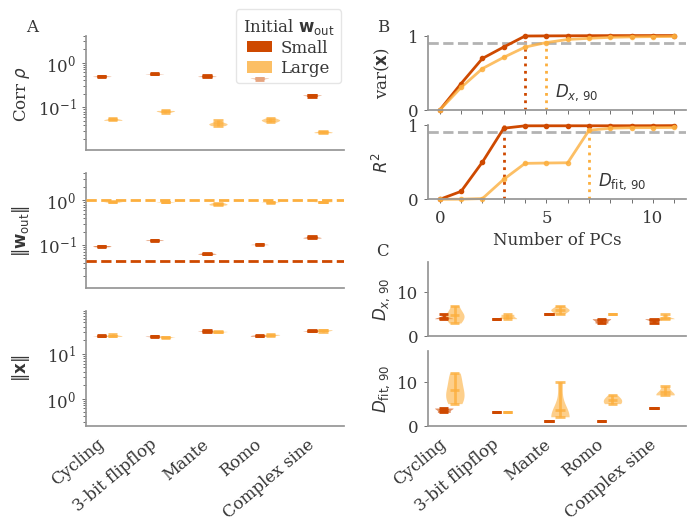

In [11]:
########################################################################
# Join all plots
fig = plt.figure(figsize=(6, 3.9), facecolor='w')

# Correlation, norms
n_rows = 3
n_cols = 1
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0., right=0.43, bottom=0., top=1., wspace=0., hspace=0.2)
axes_corr = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])
plot_corr(axes_corr)

# R^2 and PCA
n_rows = 2
n_cols = 1
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.57, right=1., bottom=0.58, top=1., wspace=0.2, hspace=0.2)
axes_r_sq = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])
plot_r_sq_cevr(axes_r_sq)

# Dimension
n_rows = 2
n_cols = 1
gs0 = GridSpec(n_rows, n_cols)
gs0.update(left=0.57, right=1., bottom=0., top=0.42, wspace=0.2, hspace=0.2)
axes_dims = np.array([[fig.add_subplot(gs0[k, j])
                  for j in range(n_cols)] for k in range(n_rows)])
plot_dims(axes_dims)
fig.align_ylabels(np.r_[axes_r_sq, axes_dims])

# Label plots
for i in range(3):
    # ax = [axes_corr[0, 0], axes_r_sq[0, 0], axes_dims[0, 0]][i]
    ax = axes_corr[0, 0]
    # xpos = -0.21 
    xpos = ([-0.21] + [+1.15]*2)[i]
    ypos = ([1.]*2 + [-0.95])[i]
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)

# Save figure
fig_name = "fig_3_neuro_corr_fit"
saving_fig(fig, figure_path, fig_name, data_type='both')